In [1]:
import numpy as np
import scida
import h5py


import config as cfg
import decomposition as de




Warning! Using default configuration. Please adjust/replace in '/cosma/home/durham/dc-lian1/.config/scida/config.yaml'.


In [2]:
import requests
import os

baseUrl = 'http://www.tng-project.org/api/'
#One needs a api-key
headers = {"api-key":"One needs a api-key"}

def get_particle(base_url, sn, subfid, params=None):
    '''
    The function downloads cutout history data file of specific subhalo (.hdf5)

    :param base_url:
        base url of file downloaded
    :param sn:
        snapshot number of cutout of subhalo data downloaded now
    :param subfid:
        subfindid of cutout of subhalo data downloaded now(correspond to snapshot number)
    :param params:
        params needed to be downloaded

    :return:
        filename of downloading
    '''
    global fail_path

    path = base_url + str(sn) + "/subhalos/" + str(subfid) + "/cutout.hdf5"

    fail_path = []
    # make HTTP GET request to path
    headers = {"api-key":"9daabd1eaca0f85eef125592b2c02b3c"}
    r = ''
    while r == '':
        try:
            r = requests.get(path, params=params, headers=headers)
        except requests.exceptions.ConnectionError as err:
            f_p = [err, ', put to sleep 5s before retrying, ', 'path is: ', path]
            fail_path.append(f_p)
            print(f_p)
            time.sleep(3)
            continue

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        # change the name of .hdf5 file
        os.rename('cutout_' + str(subfid) + '.hdf5',
                  'snap' + str(sn) + '_subfind_' + str(subfid) + '.hdf5')
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        # change the name of .hdf5 file
        os.rename('cutout_' + str(subfid) + '.hdf5',
                  'snap' + str(sn) + '_subfind_' + str(subfid) + '.hdf5')
        return filename  # return the filename string

    # change the name of .hdf5 file
    os.rename('cutout_'+str(subfid)+'.hdf5',
              'snap'+str(sn)+'_subfind_'+str(subfid) +'.hdf5')
    return r



def get_subhalo(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

In [3]:
cfg.snap=99
cfg.ID=516101

subhalo=get_subhalo("http://www.tng-project.org/api/TNG50-1/snapshots/%d/subhalos/%d/info.json"%(cfg.snap,cfg.ID))
#get_particle(base_url='http://www.tng-project.org/api/TNG50-1/snapshots/',subfid=ID, sn=cfg.snap,params=None)
particle=scida.load("./snap%d_subfind_%d.hdf5"%(cfg.snap,cfg.ID))

INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType0/EnergyDissipation'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType0/GFM_MetalsTagged'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType0/Machnumber'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType0/MagneticField'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType0/MagneticFieldDivergence'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType4/GFM_MetalsTagged'.
INFO:scida.interfaces.mixins.units.missing_units:Cannot determine units from neither unit file nor metadata for '/PartType4/StellarHsml'.
INFO:

In [4]:
timetabel=np.loadtxt("./snap_z_a.txt")
snaplist=timetabel.T[0]
scalefactorlist=timetabel.T[1]
zlist=timetabel.T[2]


cfg.z=zlist[cfg.snap]
cfg.c=scalefactorlist[cfg.snap]
cfg.h=particle.cosmology.h
cfg.Lbox=np.array([35000*cfg.c/cfg.h,35000*cfg.c/cfg.h,35000*cfg.c/cfg.h])
cfg.DMmass=3.07367708626464e-05
cfg.epsilon=0.288
cfg.Om0=particle.cosmology.Om0
cfg.Ob0=particle.cosmology.Ob0
cfg.ObL=1-particle.cosmology.Om0

In [5]:
star_coor=particle.data["PartType4"]["Coordinates"].to("kpc").magnitude.compute()
gas_coor=particle.data["PartType0"]["Coordinates"].to("kpc").magnitude.compute()
dm_coor=particle.data["PartType1"]["Coordinates"].to("kpc").magnitude.compute()

star_vel=particle.data["PartType4"]["Velocities"].to("kpc/Gyr").magnitude.compute()
gas_vel=particle.data["PartType0"]["Velocities"].to("kpc/Gyr").magnitude.compute()
dm_vel=particle.data["PartType1"]["Velocities"].to("kpc/Gyr").magnitude.compute()

star_mass=particle.data["PartType4"]["Masses"].to("Msun").magnitude.compute()
gas_mass=particle.data["PartType0"]["Masses"].to("Msun").magnitude.compute()
dm_mass=np.ones(len(dm_vel))*cfg.DMmass*1e10/cfg.h

StellarFormationTime=particle.data["PartType4"]["GFM_StellarFormationTime"].magnitude.compute()



subhalo_data={"SubhaloPos":np.array(subhalo["SubhaloPos"])*cfg.c/cfg.h,"SubhaloVel":np.array(subhalo["SubhaloVel"])*1.022712,"SubhaloHMR":subhalo["SubhaloHalfmassRadType"][4]*cfg.c/cfg.h,
             "SubhaloLenType":np.array(subhalo["SubhaloLenType"])[[0,1,4]]}
particle_data={"PartType0":{"Coordinates":gas_coor,"Velocities":gas_vel,"Masses":gas_mass},
              "PartType1":{"Coordinates":dm_coor,"Velocities":dm_vel,"Masses":dm_mass},
              "PartType4":{"Coordinates":star_coor,"Velocities":star_vel,"Masses":star_mass,"StellarFormationTime":StellarFormationTime}}

In [6]:
jzojc_s, jpojc_s, eb_s, pos_s, vel_s, mass_s,decom_mask=de.get_kinematics(subhalo_data,particle_data,RmaxoRhalf=5)

data loaded
galaxy rotated
phi,T calculated


/cosma/home/durham/dc-lian1/scida_decom/decomposition.py:394: RuntimeWarning: invalid value encountered in log10
  j_from_E = interp1d(np.log10(-E_circ)[::-1], np.log10(j_circ)[::-1], fill_value='extrapolate', bounds_error=False)
/cosma/home/durham/dc-lian1/scida_decom/decomposition.py:395: RuntimeWarning: invalid value encountered in log10
  j_circ_star = 10**j_from_E(np.log10(-te[star_index:]))


jc calculated
kinematics calculated
stellar particles selected 
all done


In [7]:
Ecut=de.get_Ecut(eb_s,mass_s)
eta_cut=de.get_etacut(jzojc_s,jpojc_s,eb_s,mass_s,Ecut,smoothing=True,sigma=1)


Ecut =  -0.6782195594980498
nbins =  401
Etacut =  0.7958621818426936


In [8]:
decomposition=de.assign_label(eb_s,jzojc_s,mass_s,Ecut,eta_cut)

In [9]:
mask_tmp = np.zeros(len(decom_mask))-99


mask_tmp[np.where(decom_mask>-2)[0][np.where(decomposition==1)]]=1
mask_tmp[np.where(decom_mask>-2)[0][np.where(decomposition==2)]]=2
mask_tmp[np.where(decom_mask>-2)[0][np.where(decomposition==3)]]=3
mask_tmp[np.where(decom_mask>-2)[0][np.where(decomposition==4)]]=4
mask_tmp[np.where(decom_mask<-2)[0]]=0

decom_mask=mask_tmp


In [10]:
particle.data["PartType4"]["Decomposition"]=decom_mask

In [11]:
particle.data["PartType4"].keys()

['BirthPos',
 'BirthVel',
 'Coordinates',
 'Decomposition',
 'GFM_InitialMass',
 'GFM_Metallicity',
 'GFM_Metals',
 'GFM_MetalsTagged',
 'GFM_StellarFormationTime',
 'GFM_StellarPhotometrics',
 'Masses',
 'ParticleIDs',
 'Potential',
 'StellarHsml',
 'SubfindDMDensity',
 'SubfindDensity',
 'SubfindHsml',
 'SubfindVelDisp',
 'Velocities']

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsi

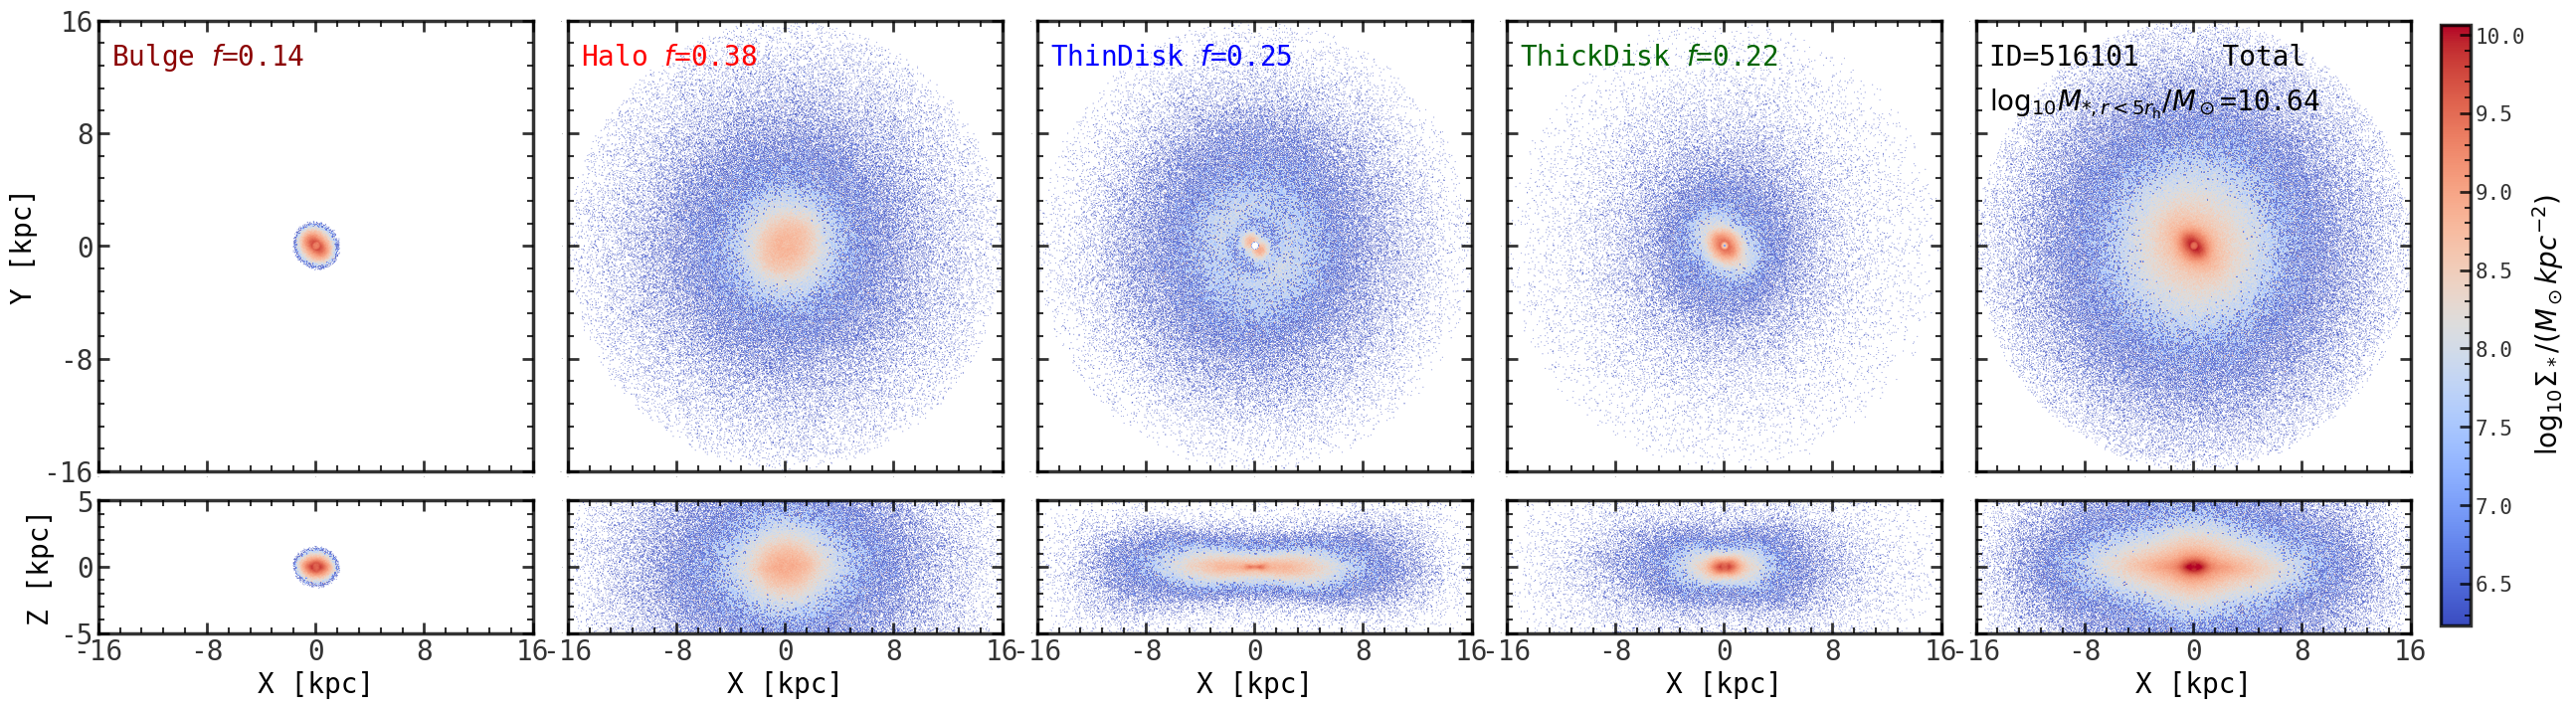

In [11]:
de.image_plot(pos_s,mass_s,vel_s,decomposition,cfg.ID,cfg.snap)

In [12]:
pwd

'/cosma/home/durham/dc-lian1/scida_decom'